In [1]:
# Modeling exam
# Vadim Zhovtanyuk
# Cisco Systems, 2020

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stat
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
import sys

In [3]:
#Loading the data into pandas dataframe
file = 'dnac-customer-bookings.csv'
data = pd.read_csv(file, sep=',', header=0, parse_dates=True)

In [4]:
#First look at the data
data

,cust,segment,vertical,sub_vertical,country,bookings,purchase
0,d66648938c68318a8dad17a77f0c8327,Commercial,Manufacturing,Hi-tech/Computers Manufacturing,UNITED STATES,103356,False
1,dcce1fa11f27a6a2c57c8aacf5f0219c,Commercial,Retail,Other (Retail),UNITED STATES,62952,True
2,136b88d1b2aea8ae74cbfe111830af69,Commercial,Retail,Other (Retail),ITALY,2886,True
3,674c6fcb90b5d29765f266007ad423e1,Enterprise,Retail,Other (Retail),UNITED STATES,80253,True
4,97c72b3833ce8ef5154826fc128522b1,Commercial,Health Care,Providers,AUSTRALIA,29424,False
...,...,...,...,...,...,...,...
27338,d95a7c1779b6165d0302e8e191243239,Enterprise,Professional Services,Construction/Engineering,UNITED STATES,4142,True
27339,24113cecc9177b25a3d22c84f9d6ceec,Enterprise,Government,Federal/Central Government,CHINA,6233,False
27340,c082a0889baf15ce697b044914e3ed44,Enterprise,Manufacturing,Discrete Manufacturing,UNITED STATES,4003,False
27341,9a28b51f3f5d510a98c8b92446ea9a00,Commercial,Retail,"Consumer Services(dry cleaners,video rental,etc)",UNITED STATES,1471,True


In [5]:
#Removing "cust" column which is unique in each row and hence not useful for further analysis
#Also, removing "vertical" and "segment" columns which seems to be redundant to sub_vertical
data = data.drop("cust", axis=1)
data = data.drop("vertical", axis=1)
data = data.drop("segment", axis=1)
data

,sub_vertical,country,bookings,purchase
0,Hi-tech/Computers Manufacturing,UNITED STATES,103356,False
1,Other (Retail),UNITED STATES,62952,True
2,Other (Retail),ITALY,2886,True
3,Other (Retail),UNITED STATES,80253,True
4,Providers,AUSTRALIA,29424,False
...,...,...,...,...
27338,Construction/Engineering,UNITED STATES,4142,True
27339,Federal/Central Government,CHINA,6233,False
27340,Discrete Manufacturing,UNITED STATES,4003,False
27341,"Consumer Services(dry cleaners,video rental,etc)",UNITED STATES,1471,True


In [6]:
#Checking if there are any "0" values
data.isnull().any()

sub_vertical    False
country         False
bookings        False
purchase        False
dtype: bool

In [7]:
#Checking "sub_vertical" column
data["sub_vertical"].value_counts()

Federal/Central Government                          3559
Other (Technical Services)                          2816
Other (Credit Card, mortgage, financing, etc.)      2573
Other (Retail)                                      2472
Wholesale/Distribution                              2384
Other (Professional Services)                       1908
Providers                                           1863
Discrete Manufacturing                              1834
Consumer Products Manufacturing                     1703
Hi-tech/Computers Manufacturing                     1575
Consulting Non-Technical                            1125
Construction/Engineering                            1013
Consumer Services(dry cleaners,video rental,etc)    1011
Real Estate                                          785
Membership organizations                             722
Name: sub_vertical, dtype: int64

In [8]:
#List of sub_vertical names
data["sub_vertical"].sort_values().unique()

array(['Construction/Engineering', 'Consulting Non-Technical',
       'Consumer Products Manufacturing',
       'Consumer Services(dry cleaners,video rental,etc)',
       'Discrete Manufacturing', 'Federal/Central Government',
       'Hi-tech/Computers Manufacturing', 'Membership organizations',
       'Other (Credit Card, mortgage, financing, etc.)',
       'Other (Professional Services)', 'Other (Retail)',
       'Other (Technical Services)', 'Providers', 'Real Estate',
       'Wholesale/Distribution'], dtype=object)

In [9]:
#Encoding "sub_vertical" column to prepare data for further analysis 
data["sub_vertical"] = data["sub_vertical"].astype("category")
sub_vertical_encode = LabelEncoder()
data["sub_vertical"] = sub_vertical_encode.fit_transform(data.sub_vertical)
data
sub_vertical_one_hot = OneHotEncoder()
sub_vertical_one_hot_encode = sub_vertical_one_hot.fit_transform(data.sub_vertical.values.reshape(-1,1)).toarray()
ohe_variable = pd.DataFrame(sub_vertical_one_hot_encode, columns = ["sub_vertical_" + str(int(i)) for i in range (sub_vertical_one_hot_encode.shape[1])])
data = pd.concat([data, ohe_variable], axis=1)
data = data.drop("sub_vertical", axis=1)

In [10]:
#Fixing different names for the same country issues
def fix(column):
    results = {}
    results['column'] = column.name

    #Replacing different names for the same country
    country_column = []
    for value in column:
        if value == "USA":
            country_column.append("UNITED STATES")
        elif value == "DEUTSCHLAND":
            country_column.append("GERMANY")
        else:
            country_column.append(value)

    #Creating new column data with 'fixed' entries
    results['data'] = country_column

    return results  

#Replacing data with new value
temp_data = data.apply(fix)
for m in temp_data:
    data[m['column']] = m['data']

In [11]:
#List of countrie names
data["country"].sort_values().unique()

array(['AUSTRALIA', 'BRAZIL', 'CANADA', 'CHINA', 'FRANCE', 'GERMANY',
       'INDIA', 'ITALY', 'JAPAN', 'MEXICO', 'UNITED KINGDOM',
       'UNITED STATES'], dtype=object)

In [12]:
#Encoding "country" column to prepare data for further analysis 
data["country"] = data["country"].astype("category")
country_encode = LabelEncoder()
data["country"] = country_encode.fit_transform(data.country)
country_one_hot = OneHotEncoder()
country_one_hot_encode = country_one_hot.fit_transform(data.country.values.reshape(-1,1)).toarray()
ohe_variable = pd.DataFrame(country_one_hot_encode, columns = ["country_" + str(int(i)) for i in range (country_one_hot_encode.shape[1])])
data = pd.concat([data, ohe_variable], axis=1)
data = data.drop("country", axis=1)

In [13]:
#Replacing "unknown" and negative values with "artifial" value "1010101"
def fix(column):
    results = {}
    results['column'] = column.name

    fix_column = []
    for value in column:
        if value == "unknown":
            fix_column.append("1010101")
        elif str(value).startswith("-"):
            fix_column.append("1010101")
        else:
            fix_column.append(value)

    #Creating new column data with 'fixed' entries
    results['data'] = fix_column

    return results  

#Replacing data with new value
temp_data = data.apply(fix)
for m in temp_data:
    data[m['column']] = m['data']

In [14]:
#Fixing "artifial" 1010101" in bookings 
def missing(column):
    results = {}
    results['column'] = column.name

    #Step1 -  Removing "1010101" entries and calcualting median 
    s1_column = [x for x in column if x != 1010101]
    results['removed_median'] = stat.median(s1_column)
    
    #Step2 - Replace "1010101" entries with (removed) median
    s2_column = []
    for value in column:
        if value != 1010101:
            s2_column.append(value)
        else:
            s2_column.append(results['removed_median'])

    #Creating new column data with 'fixed' entries
    results['data'] = s2_column

    return results

#Replace "1010101" data with mean value
ds = data.astype({'bookings': 'int64'})
missing_data = ds.select_dtypes(include=['float64', 'int64']).apply(missing)
for m in missing_data:
    ds[m['column']] = m['data']  
    
data = ds.astype({'bookings': 'float64'})    

In [15]:
scaler = MinMaxScaler()
data['bookings_scalled'] = scaler.fit_transform(data['bookings'].values.reshape(-1,1))
data = data.drop("bookings", axis=1)

In [16]:
data

,purchase,sub_vertical_0,sub_vertical_1,sub_vertical_2,sub_vertical_3,sub_vertical_4,sub_vertical_5,sub_vertical_6,sub_vertical_7,sub_vertical_8,...,country_3,country_4,country_5,country_6,country_7,country_8,country_9,country_10,country_11,bookings_scalled
0,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001022
1,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000619
2,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000019
3,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000791
4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000031
27339,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000052
27340,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000030
27341,True,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000005


In [17]:
data.groupby("purchase").size()

purchase
False    17743
True      9600
dtype: int64

In [18]:
#Purchase list booleans
data["purchase"].sort_values().unique()

array([False,  True])

In [19]:
#Encoding "purchase" column to prepare data for further analysis 
data["purchase"] = data["purchase"].astype("category")
purchase_encode = LabelEncoder()
data["purchase"] = purchase_encode.fit_transform(data.purchase)

In [20]:
data

,purchase,sub_vertical_0,sub_vertical_1,sub_vertical_2,sub_vertical_3,sub_vertical_4,sub_vertical_5,sub_vertical_6,sub_vertical_7,sub_vertical_8,...,country_3,country_4,country_5,country_6,country_7,country_8,country_9,country_10,country_11,bookings_scalled
0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001022
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000619
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000019
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000791
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000031
27339,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000052
27340,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000030
27341,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000005


In [21]:
data.describe()

,purchase,sub_vertical_0,sub_vertical_1,sub_vertical_2,sub_vertical_3,sub_vertical_4,sub_vertical_5,sub_vertical_6,sub_vertical_7,sub_vertical_8,...,country_3,country_4,country_5,country_6,country_7,country_8,country_9,country_10,country_11,bookings_scalled
count,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,...,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000,27343.000000
mean,0.351095,0.037048,0.041144,0.062283,0.036975,0.067074,0.130161,0.057602,0.026405,0.094101,...,0.067147,0.035951,0.064258,0.025784,0.028783,0.044911,0.026808,0.082142,0.517756,0.001664
std,0.477321,0.188883,0.198627,0.241673,0.188703,0.250154,0.336487,0.232993,0.160340,0.291974,...,0.250281,0.186171,0.245216,0.158492,0.167198,0.207112,0.161524,0.274585,0.499694,0.011119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000221
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000840
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


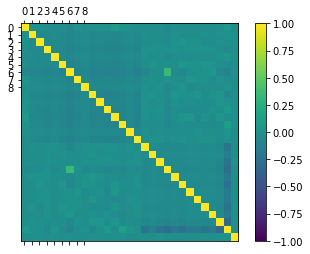

In [22]:
data.corr(method='pearson')
correlations = data.corr()
fig = plt.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(correlations, vmin=-1, vmax=1) 
fig.colorbar(cax) 
ticks = np.arange(0,9,1) 
ax.set_xticks(ticks) 
ax.set_yticks(ticks) 
plt.show()

In [23]:
#Create feature and target for classification
features = data.drop("purchase", axis=1).values
target = data["purchase"].values

In [24]:
#Split the data for training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42, stratify = target)

In [25]:
#Trying different classifiers

In [26]:
#Initializing the kNN classifier with 100 neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=100)

#Fitting the kNN classifier on the training data
knn_classifier.fit(X_train, y_train)

#Extracting the accuracy score from the test sets for kNN classifiier
knn_classifier.score(X_test, y_test)

0.6500060953309764

In [27]:
#Creating predictions on the test set 
prediction = knn_classifier.predict(X_test)

#Creating the confusion matrix
print(confusion_matrix(y_test, prediction))

[[5230   93]
 [2778  102]]


In [28]:
#Initializing an logistic regression object 
logistic_regression = linear_model.LogisticRegression()

#Fitting the logistic regression model to the training and test sets
logistic_regression.fit(X_train, y_train)

#Accuracy score of the logistic regression model 
logistic_regression.score(X_test, y_test)

0.6489089357552115

In [29]:
#Creating predictions on the test set 
prediction = logistic_regression.predict(X_test)

#Creating the confusion matrix
print(confusion_matrix(y_test, prediction))

[[5323    0]
 [2880    0]]


In [30]:
#Initializing an NB classifier
nb_classifier = GaussianNB()

#Fitting the NB classifier into the training data
nb_classifier.fit(X_train, y_train)

#Extracting the accuracy score from the NB classifier
nb_classifier.score(X_test, y_test)

0.5043276849932952

In [31]:
#Creating predictions on the test set 
prediction = nb_classifier.predict(X_test)

#Creating the confusion matrix
print(confusion_matrix(y_test, prediction))

[[2298 3025]
 [1041 1839]]


In [32]:
#Initializing the DT classifier
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 50)

#Fitting on the training data
dt.fit(X_train, y_train)

#Testing accuracy on the test data
dt.score(X_test, y_test)

0.5490674143605998

In [33]:
#Creating predictions on the test set 
prediction = dt.predict(X_test)

#Creating the confusion matrix
print(confusion_matrix(y_test, prediction))

[[3549 1774]
 [1925  955]]


In [34]:
#Initiliazing an Random Forest Classifier with default parameters
rf_classifier = RandomForestClassifier(random_state = 50)

#Fitting the classifier on the training data
rf_classifier.fit(X_train, y_train)

#Extracting the scores
rf_classifier.score(X_test, y_test)

0.5536998659027185

In [35]:
#Creating predictions on the test set 
prediction = rf_classifier.predict(X_test)

#Creating the confusion matrix
print(confusion_matrix(y_test, prediction))

[[3552 1771]
 [1890  990]]


In [36]:
#Initialize a tree (Decision Tree with max depth = 1)
dt = DecisionTreeClassifier(max_depth=1, random_state = 42)

#Initialize an AdaBoost classifier with the tree as the base estimator
ada_boost = AdaBoostClassifier(base_estimator = dt, n_estimators=100)

#Fitting the AdaBoost classifier to the training set
ada_boost.fit(X_train, y_train)

#Extracting the accuracy scores from the classifier
ada_boost.score(X_test, y_test)


0.650981348287212

In [37]:
#Creating predictions on the test set 
prediction = ada_boost.predict(X_test)

#Creating the confusion matrix
print(confusion_matrix(y_test, prediction))

[[5288   35]
 [2828   52]]


In [38]:
# [END]